# Recognize handwritten digits with advanced training methods
----------------------

- Tensorflow-GPU Version: 2.2
- GPU trained on: RTX 2080 TI 11GB Vram
- Tweak the batchsize if your GPU has not enough vram. 

----------------------
1. Import the important librarys
2. Load the data
3. Normalize the data
4. Show a few samples from the dataset
5. One-Hot-Encoding
6. Split the data into Trainingdata and Testdata
7. Expand the dimensions of the data 
8. Build the model of the neuronal network
9. Choose an Optimizer
10. Compile the model
11. Configure the Callback "ReduceLROnPlateau"
12. Configure the Callback "ModelCheckpoint"
13. Setup the ImageDataGenerator for Data Augementation
14. Train the model 
15. Test the model on unknown data 

## 1. Import the important librarys

In [1]:
import datetime
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import itertools

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (Conv2D, Dense, Dropout, Flatten,
                          GlobalAveragePooling2D, Input, MaxPool2D)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.np_utils import to_categorical  # convert to one-hot-encoding
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## 2. Load the data

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

## 3. Normalize the data

In [3]:
X_train = X_train / 255.0
X_test = X_test / 255.0
print(Y_train.shape , X_test.shape)

(60000,) (10000, 28, 28)


## 4. Show a few samples from the dataset

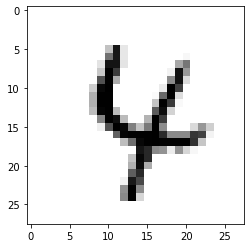

In [4]:
plt.imshow(X_train[142], interpolation='nearest', cmap=plt.cm.binary)  
plt.show()

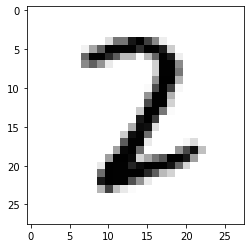

In [5]:
plt.imshow(X_test[4354], interpolation='nearest', cmap=plt.cm.binary)
plt.show()

## 5. One-Hot-Encoding

In [6]:
Y_train = to_categorical(Y_train, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

## 6. Split the data into Trainingdata and Testdata


In [7]:
random_seed = 234
X_train, X_train_val, Y_train, Y_train_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)


## 7. Expand the dimensions of the data 


In [8]:
# Transform the 
X_train = np.expand_dims(X_train, axis=-1)
X_train_val = np.expand_dims(X_train_val, axis=-1)

## 8. Build the model of the neuronal network


In [9]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.35))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.35))

model.add(Dense(10, activation = "softmax"))

## 9. Choose an Optimizer


In [10]:
optimizer = Adam(lr=0.001)

## 10. Compile the model


In [11]:
model.compile(optimizer=optimizer , loss="categorical_crossentropy", metrics=["acc"])


## 11. Configure the Callback "ReduceLROnPlateau"


In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00001)

## 12. Configure the Callback "ModelCheckpoint"


In [13]:
now = datetime.datetime.now() 
folder_name = f"./model/{now.strftime('%H-%M-%S')}" 
os.mkdir(folder_name)

filepath_check=folder_name+"/weights-improvement-{epoch:02d}-{val_acc:.6f}.h5"
checkpoint = ModelCheckpoint(
    filepath_check,
    monitor="val_acc",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
)
filepath_best=folder_name+"/weights.best.h5"
checkpoint_best = ModelCheckpoint(filepath_best, monitor='val_acc', verbose=0, save_best_only=True, mode='max')


## 13. Setup the ImageDataGenerator for Data Augementation


In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.07, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

epochs = 30
batch_size = 100
training = datagen.flow(X_train,Y_train, batch_size=batch_size)

## 14. Train the model 


In [15]:
history = model.fit(training, epochs = epochs, validation_data = (X_train_val, Y_train_val),
                              verbose = 1, steps_per_epoch=300
                              , callbacks=[learning_rate_reduction, checkpoint_best])


Epoch 1/30
300/300 [==============================] - 5s 17ms/step - loss: 0.5201 - acc: 0.8262 - val_loss: 0.0755 - val_acc: 0.9783
Epoch 2/30
300/300 [==============================] - 5s 16ms/step - loss: 0.1181 - acc: 0.9657 - val_loss: 0.0520 - val_acc: 0.9833
Epoch 3/30
300/300 [==============================] - 5s 16ms/step - loss: 0.0884 - acc: 0.9744 - val_loss: 0.0437 - val_acc: 0.9863
Epoch 4/30
300/300 [==============================] - 5s 16ms/step - loss: 0.0714 - acc: 0.9798 - val_loss: 0.0378 - val_acc: 0.9888
Epoch 5/30
300/300 [==============================] - 5s 16ms/step - loss: 0.0620 - acc: 0.9823 - val_loss: 0.0465 - val_acc: 0.9882
Epoch 6/30
300/300 [==============================] - 5s 16ms/step - loss: 0.0601 - acc: 0.9829 - val_loss: 0.0353 - val_acc: 0.9893
Epoch 7/30
300/300 [==============================] - 5s 16ms/step - loss: 0.0554 - acc: 0.9847 - val_loss: 0.0363 - val_acc: 0.9907
Epoch 8/30
300/300 [==============================] - 5s 16ms/step - 

## 15. Test the model on unknown data

In [21]:
results = model.predict(X_train_val)
count = 0
for i, result in enumerate(results):
    if np.argmax(result) == np.argmax(Y_train_val[i]): count += 1
    
print(f"Correct classified handwritten digits (nominal) => {count}")
print(f"Correct classified handwritten digits (relative) => {round((count/Y_train_val.shape[0])*100, 2)}%")

Correct classified handwritten digits (nominal) => 5973
Correct classified handwritten digits (relative) => 99.55%
